In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torch

In [2]:
import os
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor
img_size=240
batch_size=3

def load_and_preprocess_nifti(file_path):
    nifti_data = nib.load(file_path)
    nifti_array = nifti_data.get_fdata()
    nifti_tensor = torch.from_numpy(nifti_array)
    return nifti_tensor
brats18_dataset_dir = r"D:\documents\datasets\brats18\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_2_1"
file_names = os.listdir(brats18_dataset_dir)
file_paths = [os.path.join(brats18_dataset_dir, file_name) for file_name in file_names]


class BRATS18Dataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = load_and_preprocess_nifti(file_path)
        return image

brats18_dataset = BRATS18Dataset(file_paths)
brats18_dataloader = DataLoader(brats18_dataset, batch_size=batch_size, shuffle=True)



c:\Users\maha9\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Resize
from torchvision.utils import save_image

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.instancenorm = nn.InstanceNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        #print("Input tensor shape:", x.shape)
        out = self.relu(self.instancenorm(self.conv1(x)))
        #print("Intermediate tensor shape:", out.shape)
        out = self.instancenorm(self.conv2(out))
        #print("Output tensor shape:", out.shape)
        out += residual
        return out

class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=7, stride=1)
        self.norm1 = nn.InstanceNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # Downsampling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.norm3 = nn.InstanceNorm2d(64)

        # Residual blocks
        self.residual_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(6)])

        # Upsampling
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2)
        self.norm4 = nn.InstanceNorm2d(32)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2)
        self.norm5 = nn.InstanceNorm2d(16)

        # Output layer
        self.conv4 = nn.Conv2d(16, out_channels, kernel_size=7, stride=1)
        self.norm6 = nn.InstanceNorm2d(out_channels)

    def forward(self, x):
        out = self.relu(self.norm1(self.conv1(x)))
        print("in generator")
        print(out.shape)
        out = self.relu(self.norm2(self.conv2(out)))
        print(out.shape)
        out = self.relu(self.norm3(self.conv3(out)))
        print(out.shape)
        out = self.residual_blocks(out)
        print(out.shape)
        out = self.relu(self.norm4(self.deconv1(out)))
        print(out.shape)
        out = self.relu(self.norm5(self.deconv2(out)))
        print(out.shape)
        out = torch.tanh(self.norm6(self.conv4(out)))
        print(out.shape)
        return out
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=4, stride=2)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.norm1 = nn.InstanceNorm2d(32)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, )
        self.norm2 = nn.InstanceNorm2d(64)
        self.leaky_relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.norm3 = nn.InstanceNorm2d(128)
        self.leaky_relu4 = nn.LeakyReLU(0.2, inplace=True)

        self.conv5 = nn.Conv2d(128, 128, kernel_size=4, stride=1, )

    def forward(self, x):
        out = self.leaky_relu1(self.conv1(x))
        print("in discriminator")
        print(out.shape)
        out = self.leaky_relu2(self.norm1(self.conv2(out)))
        print(out.shape)
        out = self.leaky_relu3(self.norm2(self.conv3(out)))
        print(out.shape)
        out = self.leaky_relu4(self.norm3(self.conv4(out)))
        print(out.shape)
        out = self.conv5(out)
        return out


lr = 0.0002
batch_size = 64  
num_epochs = 100
img_size = 240  
latent_dim = 3  
transform = Resize((256, 256))
generator = Generator(in_channels=latent_dim, out_channels=3)
discriminator = Discriminator(in_channels=3)
epoch=0
criterion = nn.BCEWithLogitsLoss()
optim_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
generatorloss=[]
discriminatorloss=[]
while epoch < 2:
    for batch_idx, real_images in enumerate(brats18_dataloader):
        real_images = real_images
        real_images = real_images.to(torch.float32)        
        #print(real_images.shape)
        final_tensor = real_images.permute(0, 3, 1, 2)
        final_tensor = transform(final_tensor)
        #print("1",final_tensor.shape)
        reduced_img_data = torch.mean(final_tensor, dim=1, keepdim=True)
        #print(reduced_img_data.shape)
        img_tensor_3_channels = reduced_img_data.repeat(1, 3, 1, 1)
        print("initial image size ",img_tensor_3_channels.shape)
        # Train discriminator
        optim_D.zero_grad()
        # Train with real images
        real_outputs = discriminator(img_tensor_3_channels)
        d_loss_real = criterion(real_outputs, torch.ones_like(real_outputs))
        d_loss_real.backward()         
        # Train with fake images
        fake_images = generator(img_tensor_3_channels)        
        fake_outputs = discriminator(fake_images)
        d_loss_fake = criterion(fake_outputs, torch.zeros_like(fake_outputs))
        d_loss_fake.backward()
        d_loss = d_loss_real + d_loss_fake
        optim_D.step()
        # Train generator
        optim_G.zero_grad()
        z = torch.randn_like(img_tensor_3_channels)
        #print("z",z.shape)
        gen_images = generator(z)
        gen_outputs = discriminator(gen_images)
        g_loss = criterion(gen_outputs, torch.ones_like(gen_outputs))
        g_loss.backward()
        optim_G.step()
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], "
                f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}"
            )
            generatorloss.append(g_loss.item())
            discriminatorloss.append(d_loss.item())
    epoch += 1
with torch.no_grad():
    z = torch.randn_like(img_tensor_3_channels)
    gen_images = generator(z)
    print(gen_images.shape)
    save_image(gen_images, f"encryption_key.png", normalize=True)


initial image size  torch.Size([3, 3, 256, 256])
in discriminator
torch.Size([3, 16, 127, 127])
torch.Size([3, 32, 62, 62])
torch.Size([3, 64, 30, 30])
torch.Size([3, 128, 14, 14])
in generator
torch.Size([3, 16, 250, 250])
torch.Size([3, 32, 124, 124])
torch.Size([3, 64, 61, 61])
torch.Size([3, 64, 61, 61])
torch.Size([3, 32, 124, 124])
torch.Size([3, 16, 250, 250])
torch.Size([3, 3, 244, 244])
in discriminator
torch.Size([3, 16, 121, 121])
torch.Size([3, 32, 59, 59])
torch.Size([3, 64, 28, 28])
torch.Size([3, 128, 13, 13])
in generator
torch.Size([3, 16, 250, 250])
torch.Size([3, 32, 124, 124])
torch.Size([3, 64, 61, 61])
torch.Size([3, 64, 61, 61])
torch.Size([3, 32, 124, 124])
torch.Size([3, 16, 250, 250])
torch.Size([3, 3, 244, 244])
in discriminator
torch.Size([3, 16, 121, 121])
torch.Size([3, 32, 59, 59])
torch.Size([3, 64, 28, 28])
torch.Size([3, 128, 13, 13])
Epoch [0/100], Generator Loss: 0.7130, Discriminator Loss: 1.4409
initial image size  torch.Size([2, 3, 256, 256])
in d

In [4]:
encryption_key=torch.tensor(gen_images)
encryption_key

C:\Users\maha9\AppData\Local\Temp\ipykernel_9308\3336206236.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encryption_key=torch.tensor(gen_images)


tensor([[[[-0.6037, -0.0097, -0.6115,  ..., -0.1653, -0.2177,  0.1170],
          [-0.0119, -0.3622,  0.2964,  ..., -0.1541,  0.3436, -0.2303],
          [-0.4506, -0.4617, -0.8471,  ...,  0.8778, -0.1985, -0.2059],
          ...,
          [ 0.2931, -0.4613, -0.1399,  ..., -0.6024, -0.2047, -0.0070],
          [-0.4454, -0.4243, -0.8830,  ...,  0.7180, -0.7896,  0.6660],
          [-0.3018, -0.5671, -0.1982,  ..., -0.4539, -0.0995, -0.4733]],

         [[-0.3754, -0.2339, -0.6914,  ..., -0.3026,  0.0643,  0.2255],
          [ 0.2081, -0.5707, -0.3761,  ..., -0.2685,  0.0487, -0.4558],
          [ 0.2115, -0.7852,  0.1339,  ..., -0.6386, -0.4224,  0.4968],
          ...,
          [ 0.6236,  0.0775, -0.4316,  ..., -0.7693, -0.1913, -0.5644],
          [-0.1928,  0.1601,  0.2466,  ..., -0.8354, -0.5069,  0.6723],
          [-0.1616, -0.1296,  0.0499,  ..., -0.1558,  0.7674,  0.6250]],

         [[-0.8789, -0.3564, -0.4685,  ..., -0.5108, -0.4531, -0.2301],
          [-0.2869, -0.5480, -

Loading and visualizing: D:\documents\datasets\brats18\MICCAI_BraTS_2018_Data_Validation\Brats18_CBICA_ALA_1\Brats18_CBICA_ALA_1_flair.nii


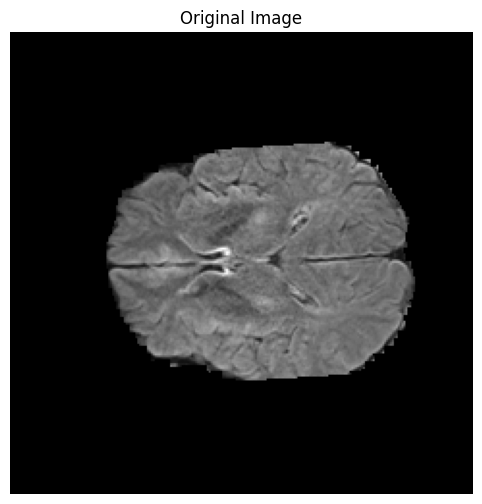

torch.Size([240, 240, 155])


In [5]:
def load_nifti_file(file_path):
    nifti_data = nib.load(file_path)
    nifti_array = nifti_data.get_fdata()
    nifti_tensor = torch.from_numpy(nifti_array)
    return nifti_tensor


def visualize_nifti(nifti_tensor):
    plt.figure(figsize=(12, 6))
    slice_w = min(25, nifti_tensor.shape[2] // 2)  
    middle_slice = nifti_tensor[:, :, nifti_tensor.shape[2] // 2]  
    plt.imshow(middle_slice, cmap='gray')  
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

original_image =r"D:\documents\datasets\brats18\MICCAI_BraTS_2018_Data_Validation\Brats18_CBICA_ALA_1"

for file_name in os.listdir(original_image):
    if file_name.endswith(".nii") or file_name.endswith(".nii.gz"):
        file_path = os.path.join(original_image, file_name)
        print("Loading and visualizing:", file_path)
        original_tensor = load_nifti_file(file_path)
        visualize_nifti(original_tensor)
        print(original_tensor.shape)
    break


In [6]:
original_tensor=original_tensor.permute(2, 1, 0)
print(original_tensor.shape)
img = original_tensor.repeat(3, 1, 1, 1)
img.shape

torch.Size([155, 240, 240])


torch.Size([3, 155, 240, 240])

In [7]:
import torch
import torch.nn.functional as F


def resize_tensor(input_tensor, target_size):
    
    resized_tensor = F.interpolate(input_tensor, size=(target_size[2], target_size[3]), mode='bilinear', align_corners=False)
    
    if resized_tensor.shape[2] < target_size[2]:
        pad_size = (target_size[2] - resized_tensor.shape[2]) // 2
        resized_tensor = F.pad(resized_tensor, (pad_size, pad_size, pad_size, pad_size))
    elif resized_tensor.shape[2] > target_size[2]:
        crop_size = (resized_tensor.shape[2] - target_size[2]) // 2
        resized_tensor = resized_tensor[:, :, crop_size:crop_size+target_size[2], :]
    
    if resized_tensor.shape[3] < target_size[3]:
        pad_size = (target_size[3] - resized_tensor.shape[3]) // 2
        resized_tensor = F.pad(resized_tensor, (pad_size, pad_size, pad_size, pad_size))
    elif resized_tensor.shape[3] > target_size[3]:
        crop_size = (resized_tensor.shape[3] - target_size[3]) // 2
        resized_tensor = resized_tensor[:, :, :, crop_size:crop_size+target_size[3]]

    return resized_tensor

target_size=(2,3,244,244)
resized_tensor = resize_tensor(img, target_size)

print("Resized tensor shape:", resized_tensor.shape)


Resized tensor shape: torch.Size([3, 155, 244, 244])


In [8]:
import torch.nn.functional as F


def reduce_channels_and_width(input_tensor, target_channels, target_width):
    
    reduced_channels_tensor = input_tensor[:target_channels]
    reduced_width_tensor = F.interpolate(reduced_channels_tensor, size=(input_tensor.shape[2], target_width), mode='bilinear', align_corners=False)
    
    return reduced_width_tensor


resize_tensor=resized_tensor.permute(0, 2, 3,1)

target_channels = 2
target_width = 3


reduced_tensor = reduce_channels_and_width(resize_tensor, target_channels, target_width)

print("Reduced tensor shape:", reduced_tensor.shape)
reduced_tensor=reduced_tensor.permute(0,3,1,2)
print("Reduced tensor shape:", reduced_tensor.shape)

Reduced tensor shape: torch.Size([2, 244, 244, 3])
Reduced tensor shape: torch.Size([2, 3, 244, 244])


In [9]:
reduced_tensor.shape

torch.Size([2, 3, 244, 244])

In [10]:
encryption_key.shape


torch.Size([2, 3, 244, 244])

In [11]:
import torch

def caesar_encrypt_image_tensor(image_tensor, key_tensor):
    
    assert image_tensor.size() == key_tensor.size(), "Image tensor and key tensor must have the same size"
    encrypted_tensor = (image_tensor + key_tensor) % 256  
    return encrypted_tensor


def caesar_decrypt_image_tensor(encrypted_tensor, key_tensor):
    assert encrypted_tensor.size() == key_tensor.size(), "Encrypted tensor and key tensor must have the same size"
    decrypted_tensor = (encrypted_tensor - key_tensor) % 256  
    return decrypted_tensor

encrypted_image_tensor = caesar_encrypt_image_tensor(reduced_tensor, encryption_key)
decrypted_image_tensor = caesar_decrypt_image_tensor(encrypted_image_tensor, encryption_key)


In [12]:
encrypted_image_tensor.shape

torch.Size([2, 3, 244, 244])

In [13]:
import torch
encrypted_img = encrypted_image_tensor.permute(1, 2, 3, 0)  
encrypted_img = encrypted_img.contiguous().view(3, 244, -1)  


In [14]:
encrypted_img.shape

torch.Size([3, 244, 488])

In [15]:
import torchvision.transforms as transforms

new_height = 244
new_width = 244

resize_transform = transforms.Resize((new_height, new_width))
resized_encrypted_img = resize_transform(encrypted_img)


In [16]:
resized_encrypted_img.shape

torch.Size([3, 244, 244])

In [17]:
resized_encrypted_img=resized_encrypted_img.permute(1,2,0)
resized_encrypted_img.shape

torch.Size([244, 244, 3])

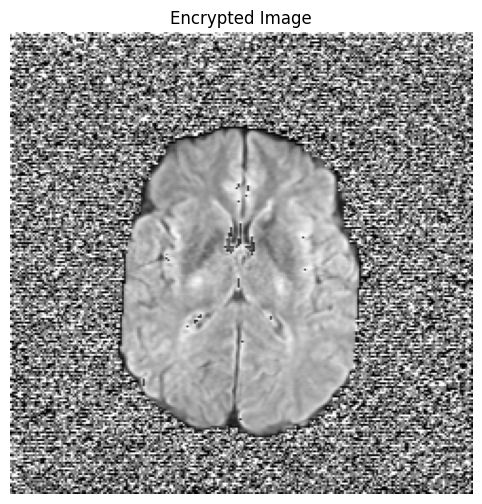

In [18]:
plt.figure(figsize=(12, 6))
slice_w = min(25, resized_encrypted_img.shape[2] // 2)  
middle_slice = resized_encrypted_img[:, :, resized_encrypted_img.shape[2] // 2]  
plt.imshow(middle_slice, cmap='gray')  
plt.title('Encrypted Image')
plt.axis('off')
plt.show()

In [19]:
decrypted_image_tensor.shape

torch.Size([2, 3, 244, 244])

In [20]:
import torch


decrypted_img = decrypted_image_tensor.permute(1, 2, 3, 0)  
decrypted_img = decrypted_img.contiguous().view(3, 244, -1)  


In [21]:
decrypted_img.shape

torch.Size([3, 244, 488])

In [22]:
import torchvision.transforms as transforms


new_height = 244
new_width = 244
resize_transform = transforms.Resize((new_height, new_width))
resized_decrypted_img = resize_transform(decrypted_img)


In [23]:
resized_decrypted_img.shape

torch.Size([3, 244, 244])

In [24]:
resized_decrypted_img=resized_decrypted_img.permute(1,2,0)
resized_decrypted_img.shape

torch.Size([244, 244, 3])

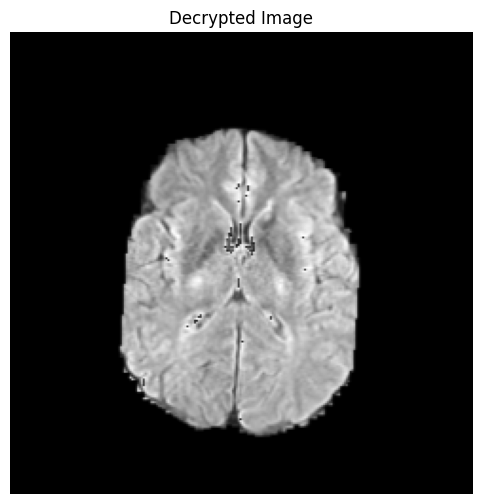

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
slice_w = min(25, resized_decrypted_img.shape[2] // 2)  
middle_slice = resized_decrypted_img[:, :, resized_decrypted_img.shape[2] // 2]  
plt.imshow(middle_slice, cmap='gray')  
plt.title('Decrypted Image')
plt.axis('off')
plt.show()


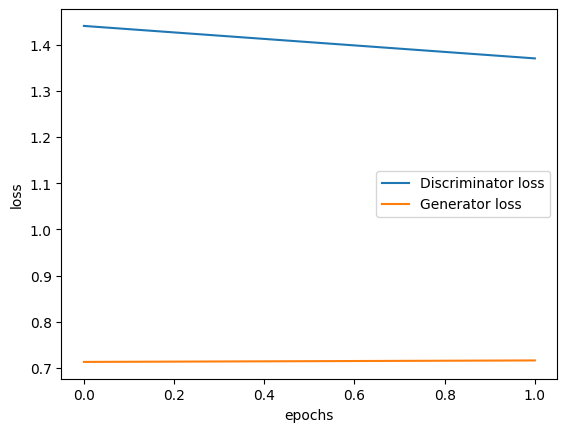

In [26]:
plt.plot(discriminatorloss,label="Discriminator loss")
plt.plot(generatorloss,label="Generator loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

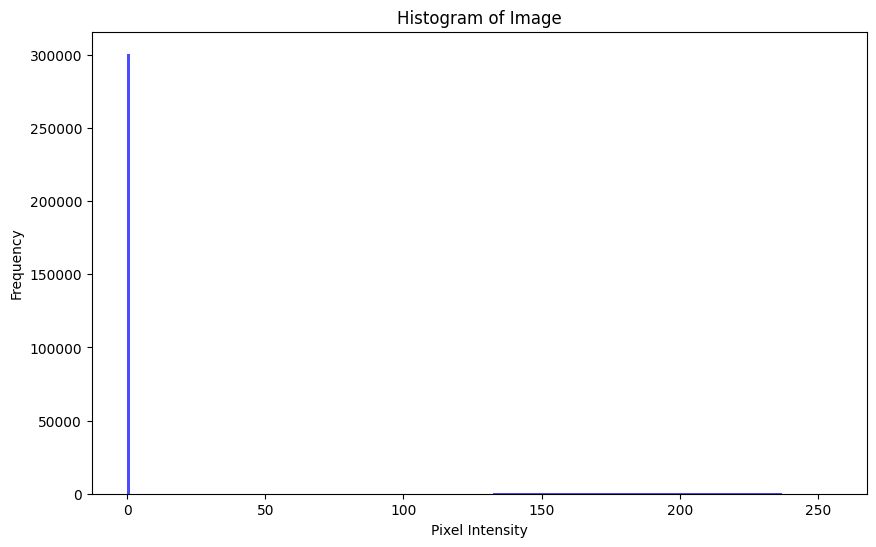

In [28]:

import numpy as np
import matplotlib.pyplot as plt


image_array = reduced_tensor.numpy()

flat_image = image_array.flatten()

plt.figure(figsize=(10, 6))
plt.hist(flat_image, bins=256, range=(0, 255), color='b', alpha=0.7)
plt.title('Histogram of Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()



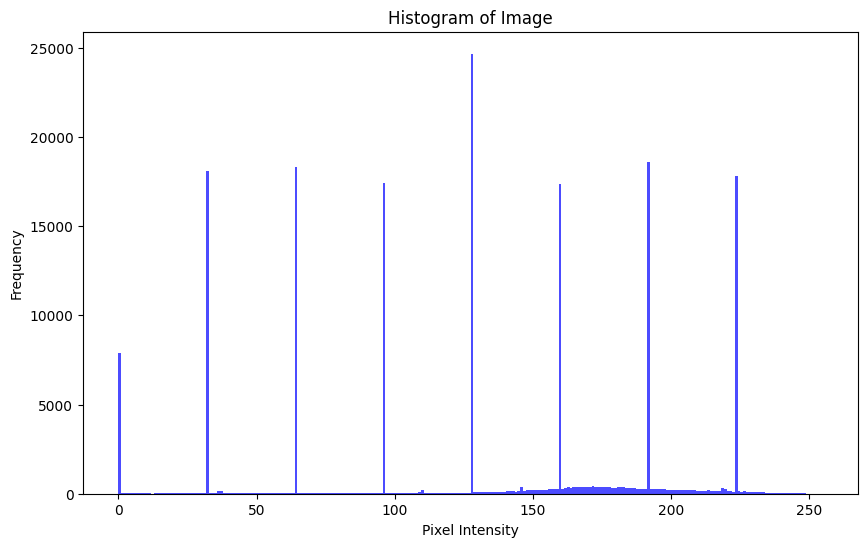

In [29]:
import numpy as np
import matplotlib.pyplot as plt


image_array = resized_encrypted_img.numpy()
flat_image = image_array.flatten()
plt.figure(figsize=(10, 6))
plt.hist(flat_image, bins=256, range=(0, 255), color='b', alpha=0.7)
plt.title('Histogram of Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

